# Raman Hackathon
---

In [1]:
from pathlib import Path
from tqdm.notebook import tqdm
from natsort import natsorted

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

In [2]:
import boto3


def get_aws_bucket(bucket_name, aws_credentials_file):
    """Get AWS bucket 

    Parameters
    ----------
    bucket_name : str
        Name of AWS bucket.
    aws_credentials_file : str | Path
        Filepath to AWS credentials file. Typically
        ~/.aws/credentials

    Returns
    -------
    bucket : `s3.Bucket`
        AWS bucket.
    """
    # parse aws credentials
    with open(aws_credentials_file, "r") as txt:
        for line in txt.read().splitlines():
            if "aws_access_key_id" in line:
                access_key = line.split(" = ")[-1]
            if "aws_secret_access_key" in line:
                secret_key = line.split(" = ")[-1]

    # create boto3 session
    session = boto3.Session(
        aws_access_key_id=access_key,
        aws_secret_access_key=secret_key,
    )

    # get bucket
    bucket = session.resource("s3").Bucket(bucket_name)
    return bucket

In [3]:
AWS_BUCKET = "arcadia-disco-raman-hackathon"
AWS_CREDENTIALS = Path(
    "/Users/ryanlane/.aws/credentials"
)

bucket = get_aws_bucket(AWS_BUCKET, AWS_CREDENTIALS)

## Beer
---

### Load beer info

Table of brewery, ABV, IBU, hops, etc. regarding each beer.

In [4]:
# read csv file from AWS bucket
s3_object = bucket.Object("data/beer/BEER_data.csv")
df_beer_info = pd.read_csv(s3_object.get()["Body"]).set_index("Sample")
num_beers = len(df_beer_info)

# sort beers by ABV
beers_sorted_abv = df_beer_info.sort_values(
    "ABV (%)", ascending=False
)["Beer"].to_dict()

# show table
df_beer_info.sort_values("ABV (%)", ascending=False)

,Beer,Brewery,Brewery Location,ABV (%),Style,IBU,Hops,Untappd Rating,Untappd Tags
Sample,,,,,,,,,
1,Dark Majik,Lough Gill,"Sligo, Ireland",11.0,Imperial Irish Oatmeal Coffee Stout,0.00,NaN,3.91,Coffee; Smooth; Rich; Sweet; Boozy
2,Sneaky AF,Del Cielo Brewing Co,"Martinez, CA",10.0,Triple IPA,0.00,"CTZ, El Dorado, Summit, Idaho 7",3.99,Balanced; Aromatic; Light Bodied; Earth; Piney
3,Big Love,Almanac,"Alameda, CA",9.0,Hazy Double IPA,0.00,"Mosaic, Centennial, Citra",3.88,Hoppy; Citrus; Smooth; Strong; Light Bodied
4,Gnomes gone rogue,Original Pattern,"Oakland, CA",8.1,Hazy Double IPA,0.00,"NZ Rakau, Mosaic, Citra",4.13,Hazy; Juicy; Hoppy; Pineapple; Malty
5,Otto’s Jacket,Cellarmaker,"Oakland, CA",7.0,West Coast IPA,58.00,"Citra, Mosaic, HBC 586, Motueka",3.99,Piney; Hoppy; Light Bodied; Tropical; Clean
8,Kimchi Sour,Dokkaebier,"Oakland, CA",6.6,Sour,14.00,NaN,3.56,Ginger; Tart; Light Bodied; Spicy; Smoky
6,Love,Almanac,"Alameda, CA",6.1,Hazy IPA,0.00,"Sabro, Citra, Mosaic",3.88,Hazy; Juicy; Smooth; Hoppy; Tropical
7,Colour Me Murphy,Original Pattern Brewing,"Oakland, CA",6.0,Irish Red Ale,0.00,NaN,3.86,"Malty, Smooth, Caramel, Sweet Dry"
9,Hunky Jesus,Laughing Monk,"San Francisco, CA",5.5,Blood orange pale ale,0.00,NaN,3.71,"Clean, Citrus, Orange, Dry, Hoppy"


### Load beer spectra

In [5]:
beer_spectra = {}
for s3_object in bucket.objects.all():
    if "data/beer/spectra" in s3_object.key and s3_object.key.endswith(".csv"):

        path = Path(s3_object.key)
        beer_index = int(path.parent.name.split("_")[0])
        key = (beer_index, path.stem)
        df_spectrum = pd.read_csv(s3_object.get()["Body"])
        beer_spectra[key] = df_spectrum["Intensity (a.u.)"].values

### Plot spectra

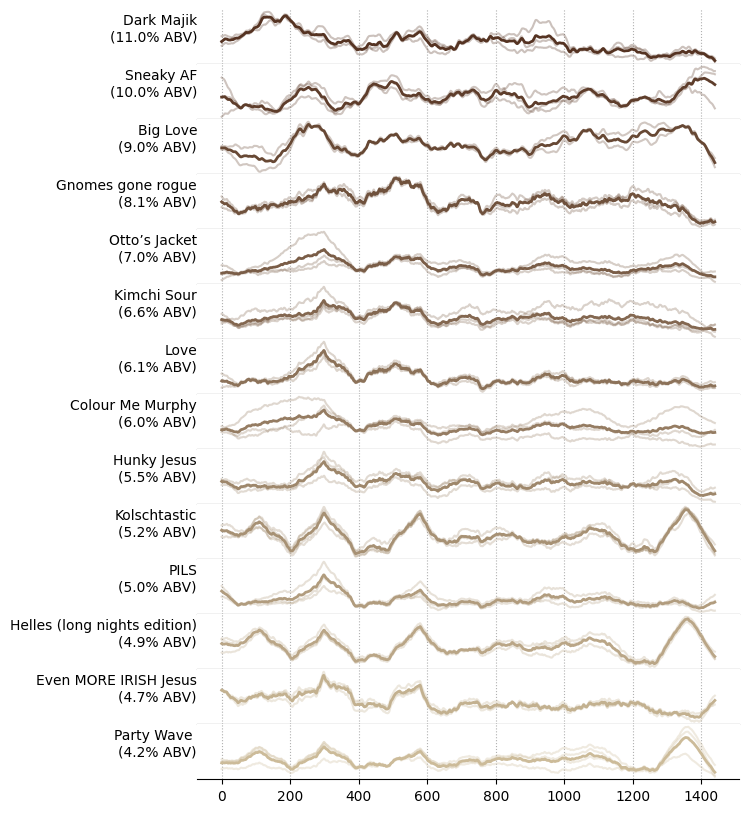

In [6]:
# create figure
fig, axes = plt.subplots(
    nrows=num_beers,
    figsize=(7, 10)
)

# define a colormap
cmap = LinearSegmentedColormap.from_list(
    name="",
    colors=["#553322", "#ccbb99"],
    N=num_beers,
)

# loop through Raman spectra for each beer
for i, (beer_index, beer_name) in enumerate(beers_sorted_abv.items()):

    # get the spectra for each beer as an array
    spectra = np.array(
        [v for k, v in beer_spectra.items() if k[0] == beer_index]
    )

    # set matplotlib axis
    ax = axes[i]
    # set color from colormap
    color = cmap(i)

    # plot each spectrum with a little bit of transparency
    # and the mean spectrum a bit more bold
    [ax.plot(spectrum, color=color, alpha=0.3) for spectrum in spectra]
    ax.plot(spectra.mean(axis=0), color=color, lw=2)

    # axis-level aesthetics
    abv = df_beer_info.loc[beer_index, "ABV (%)"]
    title = f"{beer_name}\n({abv:.1f}% ABV)"
    ax.set_title(title, loc="left", y=0.5, va="center", ha="right", fontsize=10)
    ax.get_yaxis().set_ticks([])
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(ls=":")

# figure-level aesthetics
fig.subplots_adjust(hspace=0)
plt.savefig("../pub/figures/panel_A.svg", dpi=144)

## Fuckin Small Ass Chilis
---

### Load chili pepper info

Table of chili variety, spiciness species, etc. regarding each pepper.

In [7]:
# read csv from AWS bucket
s3_object = bucket.Object("data/peppers/chili_data_updated.csv")
df_pepper_info = pd.read_csv(s3_object.get()["Body"], index_col=0)
# filter to only seed data
df_pepper_info = df_pepper_info.loc[df_pepper_info["sample_type"] == "seed"]
num_peppers = len(df_pepper_info)

# sort peppers by heat (Scoville)
peppers_sorted_heat = df_pepper_info.sort_values(
    "mean_scoville", ascending=False
)["chili_variety"].to_dict()

# show table
df_pepper_info.sort_values("mean_scoville", ascending=False)

,Abbreviation,chili_variety,chili_condition,sample_type,species_name,scoville,max_scoville,min_scoville,mean_scoville,color
8,OrHa,Orange Habanero,fresh,seed,Capsicum chinense,150000-350000,150000,350000,250000,orange
6,ReTh,Red thai,fresh,seed,Capsicum annuum,110000,110000,110000,110000,red
5,GrTh,Green Thai,fresh,seed,Capsicum annuum,50000-100000,50000,100000,75000,green
10,InLo,Indian Long chili,fresh,seed,Capsicum annuum,25000-100000,25000,100000,62500,green
14,CrRe,Crushed red chili,dried,seed,NaN,32000-48000,32000,48000,40000,red
17,Arbol,Chili de arbol,dried,seed,NaN,15000-30000,15000,30000,22500,red
18,Serr,Serrano,fresh,seed,NaN,10000-23000,10000,23000,16500,red
20,YeWa,Yellow wax,fresh,seed,NaN,5000-15000,5000,15000,10000,yellow
1,HuWa,Hungarian Wax,fresh,seed,Capsicum annuum var. annuum 'Hungarian wax',1000-15000,1000,15000,8000,yellow
13,Fres,Fresno,fresh,seed,Capsicum annuum,2500-10000,2500,10000,6250,red


### Load pepper spectra

Pepper spectra are not organized into subdirectories, so using the a priori knowledge that there are 3 csvs per pepper.

In [8]:
pepper_spectra = {}
i = 0
for s3_object in bucket.objects.all():
    if "data/peppers/pepper_seeds/" in s3_object.key and s3_object.key.endswith(".csv"):

        path = Path(s3_object.key)
        row = i // 3 + 1
        # pepper = df_pepper_info.iloc[row]["chili_variety"]
        # pepper_index = int(path.parent.name.split("_")[0])
        key = (row, path.stem)
        df_spectrum = pd.read_csv(s3_object.get()["Body"])
        pepper_spectra[key] = df_spectrum["Intensity (a.u.)"].values
        i += 1

### Plot spectra

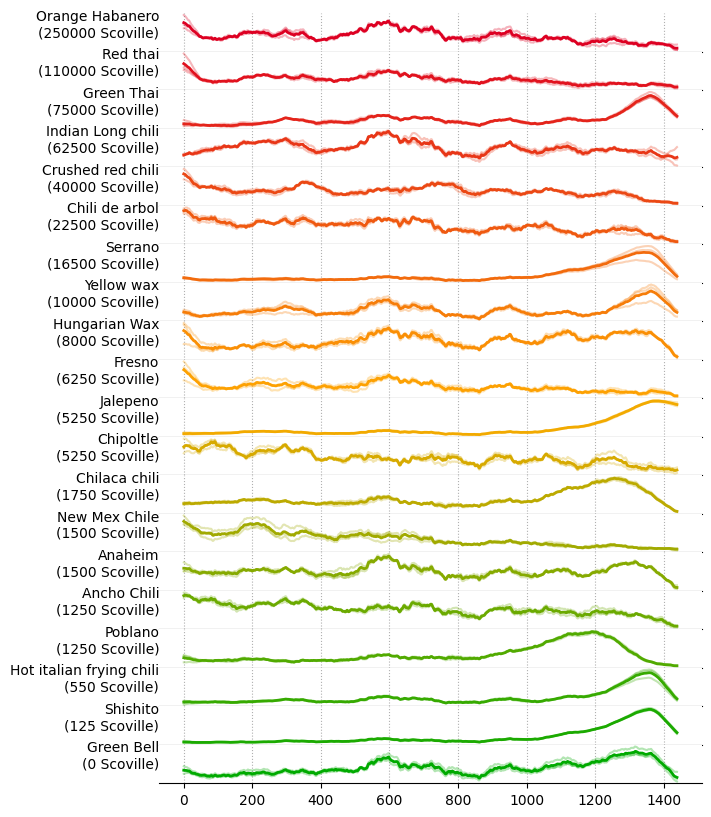

In [9]:
# create figure
fig, axes = plt.subplots(
    nrows=num_peppers,
    figsize=(7, 10)
)

# define a colormap
cmap = LinearSegmentedColormap.from_list(
    name="",
    colors=["#dd0022", "#ffaa00" ,"#00aa00"],
    N=num_peppers,
)

# loop through Raman spectra for each pepper
for i, (pepper_index, pepper_name) in enumerate(peppers_sorted_heat.items()):

    # get the spectra for each pepper as an array
    spectra = np.array(
        [v for k, v in pepper_spectra.items() if k[0] == pepper_index]
    )

    # set matplotlib axis
    ax = axes[i]
    # set color from colormap
    color = cmap(i)

    # plot each spectrum with a little bit of transparency
    # and the mean spectrum a bit more bold
    [ax.plot(spectrum, color=color, alpha=0.3) for spectrum in spectra]
    ax.plot(spectra.mean(axis=0), color=color, lw=2)

    # axis-level aesthetics
    heat = df_pepper_info.loc[pepper_index, "mean_scoville"]
    title = f"{pepper_name}\n({heat:.0f} Scoville)"
    ax.set_title(title, loc="left", y=0.5, va="center", ha="right", fontsize=10)
    ax.get_yaxis().set_ticks([])
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(ls=":")

# figure-level aesthetics
fig.subplots_adjust(hspace=0)
plt.savefig("../pub/figures/panel_B.svg", dpi=144)

## Chlamy
---

### Load organism info

Table of species.

In [10]:
# read csv from AWS bucket
s3_object = bucket.Object("data/chlamy/chlamy/aquisition_order.txt")
df_chlamy_info = pd.read_csv(s3_object.get()["Body"], header=None, names=["Species"])
num_chlamy = len(df_chlamy_info)

# sort chlamy but not really
chlamy_sorted = df_chlamy_info["Species"].to_dict()

# show table
df_chlamy_info

,Species
0,cc124
1,cc1373
2,13f6
3,13f5
4,13f4
5,13f3
6,I.gal


### Load chlamy spectra

Chlamy spectra are not organized into subdirectories, so using the a priori knowledge that there are 3 csvs per organism.

In [15]:
chlamy_spectra = {}
i = 0
for s3_object in bucket.objects.all():
    if "data/chlamy/chlamy/" in s3_object.key and s3_object.key.endswith(".csv"):

        path = Path(s3_object.key)
        row = i // 3
        key = (row, path.stem)
        df_spectrum = pd.read_csv(s3_object.get()["Body"])
        chlamy_spectra[key] = df_spectrum["Intensity (a.u.)"].values
        i += 1

### Plot spectra

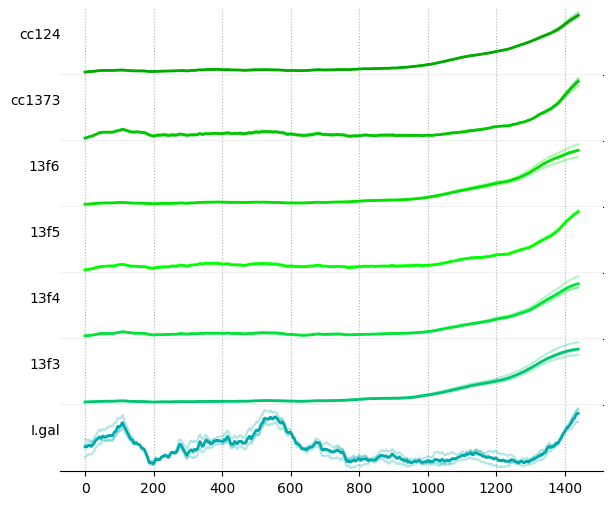

In [16]:
# create figure
fig, axes = plt.subplots(
    nrows=num_chlamy,
    figsize=(7, 6)
)

# define a colormap
cmap = LinearSegmentedColormap.from_list(
    name="",
    colors=["#00aa00", "#00ff00" ,"#00aaaa"],
    N=num_chlamy,
)

# loop through Raman spectra for each species
for i, (chlamy_index, chlamy_name) in enumerate(chlamy_sorted.items()):

    # get the spectra for each species as an array
    spectra = np.array(
        [v for k, v in chlamy_spectra.items() if k[0] == chlamy_index]
    )

    # set matplotlib axis
    ax = axes[i]
    # set color from colormap
    color = cmap(i)

    # plot each spectrum with a little bit of transparency
    # and the mean spectrum a bit more bold
    [ax.plot(spectrum, color=color, alpha=0.3) for spectrum in spectra]
    ax.plot(spectra.mean(axis=0), color=color, lw=2)

    # axis-level aesthetics
    title = f"{chlamy_name}"
    ax.set_title(title, loc="left", y=0.5, va="center", ha="right", fontsize=10)
    ax.get_yaxis().set_ticks([])
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(ls=":")

# figure-level aesthetics
fig.subplots_adjust(hspace=0)
plt.savefig("../pub/figures/panel_C.svg", dpi=144)